# mount drive

In [1]:
use_colaboratory = True
if use_colaboratory:
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/tabular-playground-series-mar-2022/notebook')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import packages
import datetime
import math
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [3]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

In [4]:
data = pd.concat([train, test])
data["time"] = pd.to_datetime(data["time"])
data["hour"] = data["time"].dt.hour
data["minute"] = data["time"].dt.minute
data["weekday"] = data["time"].dt.weekday
data = pd.get_dummies(data, columns=["direction"])
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

In [5]:
X_train = train.drop(["time", "congestion"], axis=1)
y_train = train["congestion"]
X_test = test.drop(["time", "congestion"], axis=1)

In [6]:
direction_col = [col for col in X_train.columns if "direction" in col]
categorical_features = ["x", "y"] + direction_col

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = {}

cv = TimeSeriesSplit(n_splits=5)

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx[fold_idx] = [tr_idx, val_idx]
    print(f"======== fold: {fold_idx} ========")
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr,
                            categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
                           categorical_feature=categorical_features)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 11.2236	valid_1's l1: 11.3364
[20]	training's l1: 9.95141	valid_1's l1: 10.0803
[30]	training's l1: 9.13103	valid_1's l1: 9.26307
[40]	training's l1: 8.5579	valid_1's l1: 8.69045
[50]	training's l1: 8.13106	valid_1's l1: 8.27021
[60]	training's l1: 7.82375	valid_1's l1: 7.96824
[70]	training's l1: 7.58433	valid_1's l1: 7.73441
[80]	training's l1: 7.41299	valid_1's l1: 7.57233
[90]	training's l1: 7.27442	valid_1's l1: 7.44042
[100]	training's l1: 7.19759	valid_1's l1: 7.36998
[110]	training's l1: 7.10605	valid_1's l1: 7.28406
[120]	training's l1: 7.04433	valid_1's l1: 7.22818
[130]	training's l1: 6.98956	valid_1's l1: 7.17906
[140]	training's l1: 6.94339	valid_1's l1: 7.13949
[150]	training's l1: 6.90299	valid_1's l1: 7.10553
[160]	training's l1: 6.85711	valid_1's l1: 7.06452
[170]	training's l1: 6.80265	valid_1's l1: 7.01547
[180]	training's l1: 6.77175	valid_1's l1: 6.99261
[190]	training's l1: 6.734	val

In [7]:
with open("../output/y_preds_003.pickle", "wb") as f:
    pickle.dump(y_preds, f)

In [8]:
with open("../output/models_003.pickle", "wb") as f:
    pickle.dump(models, f)

In [9]:
with open("../output/oof_train_003.pickle", "wb") as f:
    pickle.dump(oof_train, f)

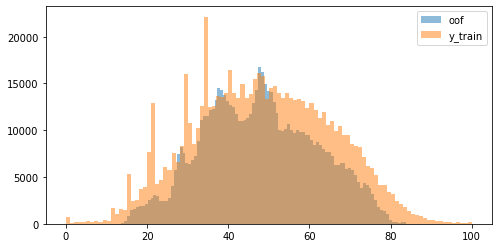

In [10]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[cv_idx[0][1][0]:], bins=100, label="oof", alpha=0.5)
plt.hist(y_train.iloc[cv_idx[0][1][0]:], bins=100, label="y_train", alpha=0.5)
plt.legend()

In [11]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[6.416102431883887, 6.470478961243288, 6.7102145884322315, 6.474914646437908, 6.7946855734222495]
6.573279240283912


In [12]:
submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = y_preds[-1]
submission.to_csv("../submit/submission_003.csv", index=False)

### submit

In [13]:
import json
with open('../../kaggle.json') as f:
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

!pip install kaggle --upgrade
!kaggle -v

Kaggle API 1.5.12


In [14]:
# submission
!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_003.csv -m "003"

100% 57.5k/57.5k [00:03<00:00, 16.9kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022